In [118]:
#IMPORT for Training
import os
import numpy as np
from imageio.v2 import imread
from scipy.io import loadmat
import random
import itertools
import cv2 as cv
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16,MobileNetV2
from keras.optimizers import SGD
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout,Activation
from keras.models import Model, load_model, Sequential
from keras.utils import to_categorical
from keras.optimizers.schedules import ExponentialDecay

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.callbacks import EarlyStopping
import ast



In [119]:
#IMPORT for prediction
import os
import numpy as np
from scipy.io import loadmat
import random
import time
import itertools
import cv2 as cv
from keras.models import load_model


In [120]:
original_path = "C:/Users/asent/Desktop/S4_Barcelona/FaceDetection/FACE_DETECTION_CHALLENGE/"
# TrainingimgPath       = original_path + "TRAINING/"
imgPath    = original_path + "AllImages/"
# Saving_folder = original_path + "Cropped/"
folder_name = original_path + "Dataset"

Training_rate   = 0.80
validation_rate = 0.20


In [136]:
#Parameters
nb_epochs = 20
nb_classes = 80
batch_size = 32
# with_early_stopping = False
IMAGE_SIZE = 180
colored = False
img_channels = 3 if colored else 1


In [137]:
#-- Face detection
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_alt.xml')

#parameter for the detection
scaleFactor  = 1.05
minNeighbors = 6
minsize      = 100
# maxsize      = 700

#I have to change the minsize for new images because they are 
def MyFaceDetectionFunction(img): #from lab 1
    frame_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)

    #-- Detect faces
    faces = face_cascade.detectMultiScale(
        frame_gray, 
        scaleFactor  = scaleFactor, 
        minNeighbors = minNeighbors, 
        minSize      = (minsize, minsize),
        # maxSize      = (maxsize, maxsize)
    )
    return faces

def select_two_biggest_faces(faces):
    areas = []
    M =[]
    for (x,y,w,h) in faces:
        x1 = x
        y1 = y
        x2 = x1 + w 
        y2 = y1 + h
        M.append([x1,y1,x2,y2])
        areas.append(w*h)
        
    if len(M)>2:
        first_face = 0
        second_face = 1
        if areas[first_face]<areas[second_face]: #check if the biggest face is on index 2, then swap index
            first_face, second_face = 1, 0
        for j in range(2,len(M)):
            if areas[j]>areas[first_face]:
                second_face = first_face
                first_face  = j
            elif areas[j]> areas[second_face]:
                second_face = j
        M = [M[first_face],M[second_face]]
    return M

def Save_detection(img,M,img_name):
    """draw the rectangle on the original image and save the image in the saving folder"""
    # M2 = MyFaceDetectionFunction(img)
    
    for rect in M:
        cv.rectangle(img,(rect[0],rect[1]),(rect[2],rect[3]),(0,0,255),4)
        
    # for rect in M2:
    #     cv.rectangle(img,(rect[0],rect[1]),(rect[2],rect[3]),(0,255,0),4)
    cv.imwrite(Saving_folder + img_name, img)
    # cv.imshow(img)
    
#Preprocessing of the Data
def process_image(img):
    img_resized = cv.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    if not colored:
        grey_img = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)
        face_normalized = grey_img /255.0
        face = np.expand_dims(face_normalized, axis=-1) 
        return face

    else:
        colored_img = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB)
        face_normalized = colored_img /255.0

        return face_normalized
    
def crop_and_normalize_image(img,faces):
    cropped_and_normalized_faces =[]
    for (x1, y1, x2, y2) in faces:
            face = img[y1:y2, x1:x2]
            processed_image = process_image(face)
            cropped_and_normalized_faces.append(processed_image)
            # cv.imwrite(Saving_folder + im, img_resized)
    return cropped_and_normalized_faces

def detect_crop_and_normalize_image(img):
    # We apply face detection
    facesDetected = MyFaceDetectionFunction(img)
    cropped_and_normalized_faces=[]
    # We select the two biggest faces
    faces = select_two_biggest_faces(facesDetected)    
    have_a_face = len(faces)>0
    # Save_detection(img,faces,im)
    if have_a_face:
        #-- Handle images with detected faces
        have_a_face = True
        # Crop, normalize, and collect faces if detected
        cropped_and_normalized_faces = crop_and_normalize_image(img,faces)
    return cropped_and_normalized_faces,have_a_face


    
def normalize_and_crop_faces(df, directory, display =False):
    #-- parameters for the grid plot
    nDisplay = 3
    ncols = 3  # for example, change as needed
    nrows = 1
    imgDisplayed = 0
    plt.figure(figsize=(9,12))  # Adjust the size as needed

    cropped_and_normalized_faces = []
    labels=[]
    image_names =[]
    for index, row in df.iterrows():
        filepath = os.path.join(directory, row['Image'])
        img = cv.imread(filepath)
        
        if img is not None:
            faces = row['Faces']
            have_a_face = len(faces) > 0   
            if have_a_face:
                images = crop_and_normalize_image(img,faces)
                for _ in range(len(faces)):
                    labels.append(row['Label'])
                    image_names.append(row['Image'])
               
                # Crop, normalize, and collect faces if detected
                cropped_and_normalized_faces += images                
                if imgDisplayed<nDisplay and display:
                    plt.subplot(nrows, ncols, imgDisplayed+1)  # Create a subplot for each image
                    imgDisplayed +=1
                    plt.imshow(images[0])
                    plt.title(str(row['Image']).replace(".jpg","")+" with ID = "+ str(row['Label']))
                    plt.axis('off')
                        
            else:
                #-- Handle images without detected faces
                # Resize the original image and normalize
                cropped_and_normalized_faces.append(process_image(img))
                labels.append(row['Label'])
                image_names.append(row['Image'])


    plt.show()
    return np.array(cropped_and_normalized_faces), np.array(labels),np.array(image_names)
    # return cropped_and_normalized_faces, labels


In [138]:
#import the new dataset
import json

with open('new_data.json', 'r') as file:
    new_data = json.load(file)
print(len(new_data))    


1802


In [139]:
#We start loading the data
challenge = loadmat('AGC_Challenge3_Training.mat')
data      = challenge['AGC_Challenge3_TRAINING'][0]
data_extended = []

for item in data:
    label = item[0][0][0]
    image = item[1][0]
    # Handling faces, assuming faces data is in item[2]
    faces = item[2] if len(item[2]) > 0 else []
    if faces != []:
        data_extended.append([label, image, faces])

print(len(data_extended))
#add the new data 
data_extended += new_data

# Convert the extended list to a DataFrame
df_extended = pd.DataFrame(data_extended, columns=['Label', 'Image', 'Faces'])

print(len(new_data))

628
1802


C:\Users\asent\AppData\Local\Temp\ipykernel_22672\2691050494.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces != []:


In [140]:
# Split the Dataset into Training Dataset and Validation Dataset
train_df, val_df = train_test_split(df_extended, test_size=validation_rate, random_state=42, stratify=df_extended['Label'])
train_df.head()


,Label,Image,Faces
2117,72,image_A2585.jpeg,"[[152, 113, 301, 262]]"
75,76,image_A0150.jpg,"[[327, 226, 574, 473], [1, 292, 94, 426]]"
870,21,image_A1471.jpeg,"[[100, 95, 231, 226]]"
474,79,image_A0888.jpg,"[[71, 65, 221, 238]]"
1040,32,image_A5046.jpeg,"[[1313, 172, 1623, 482]]"


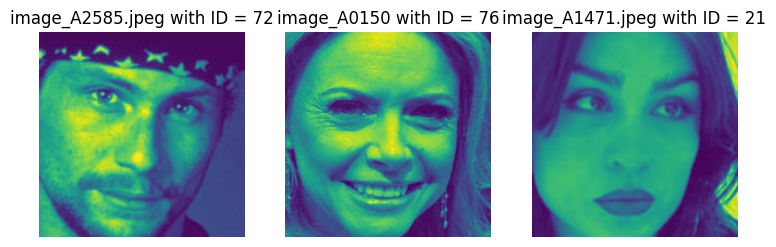

<Figure size 900x1200 with 0 Axes>

(1962, 224, 224, 1)
(1962,)
(493, 224, 224, 1)


In [141]:
##--TEST
Training_cropped_faces  , Training_face_labels  ,Training_image_names   = normalize_and_crop_faces(train_df, imgPath, display=True)
Validation_cropped_faces, Validation_face_labels,Validation_image_names = normalize_and_crop_faces(val_df, imgPath)
print(Training_cropped_faces.shape)
print(Training_face_labels.shape)
print(Validation_cropped_faces.shape)


In [142]:
##additionnal_functions
def count_version(label_val):
    count_ = [0 for i in range(81)]
    for k in range(len(label_val)):
        label = label_val[k]
        if label ==-1:
            count_[0] +=1
        else:
            count_[label] +=1
    return(count_)

counter = count_version(df_extended['Label'])
print(counter)


[148, 29, 13, 10, 11, 11, 10, 41, 40, 32, 42, 12, 27, 39, 30, 12, 12, 16, 30, 42, 38, 24, 33, 36, 14, 14, 50, 36, 16, 26, 14, 14, 35, 22, 52, 38, 30, 25, 52, 26, 27, 17, 39, 41, 49, 38, 22, 22, 15, 28, 30, 57, 26, 35, 15, 33, 32, 35, 35, 26, 18, 18, 37, 25, 4, 15, 42, 24, 33, 26, 57, 43, 25, 44, 36, 31, 25, 4, 46, 25, 28]


In [143]:
#CLASS DATASET
class dataset() :
    def __init__(self,Training_images, Training_labels,Validation_images, Validation_labels):
        self.X_train = Training_images
        self.X_valid = Validation_images
        self.Y_train = Training_labels
        self.Y_valid = Validation_labels

    def augment_image(self,image):
        """
        Apply random transformations to a single image to augment it.
        The input image is expected to be a NumPy array of shape (224, 224, 1).
        """
        # Convert single image to batch format by adding an extra dimension
        image_batch = np.expand_dims(image, axis=0)

        # Create an ImageDataGenerator instance for augmentation
        augmenter = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Generate augmented images (here, we generate a single one)
        augmented_image = next(augmenter.flow(image_batch, batch_size=5))

        # Remove batch dimension and return the augmented image
        return augmented_image[0]

    def augment_dataset(self,X, y, augmentation_factor=5):
        """
        Augment a dataset of images X with labels y, repeating the process 'augmentation_factor' times.
        Each original image will have 'augmentation_factor' augmented versions in the new dataset.
        """
        X_augmented = []
        y_augmented = []

        for i in range(len(X)):
            # Original image and label
            X_augmented.append(X[i])
            y_augmented.append(y[i])

            # Generate augmented images
            for _ in range(augmentation_factor):
                augmented_image = self.augment_image(X[i])
                X_augmented.append(augmented_image)
                y_augmented.append(y[i])  # Keep the same label for the augmented image

        return np.array(X_augmented), np.array(y_augmented)

    def read(self, nb_classes=nb_classes,img_size=IMAGE_SIZE, img_channels=img_channels):

        self.X_train = self.X_train.reshape(-1, img_size, img_size, img_channels)
        self.X_valid = self.X_valid.reshape(-1, img_size, img_size, img_channels)

        self.Y_train[self.Y_train == -1] = 0
        self.Y_valid[self.Y_valid == -1] = 0

        self.X_train,self.Y_train = self.augment_dataset(self.X_train,self.Y_train,1)
        print('X_train shape:', self.X_train.shape)
        print(self.X_train.shape[0], 'train samples')
        print(self.Y_train.shape[0], 'valid samples')
        
        # convert class vectors to binary class matrices
        self.Y_train = to_categorical(self.Y_train, nb_classes)
        self.Y_valid = to_categorical(self.Y_valid, nb_classes)


In [144]:
data = dataset(Training_cropped_faces, Training_face_labels,Validation_cropped_faces, Validation_face_labels)
data.read()


X_train shape: (3924, 224, 224, 1)
3924 train samples
3924 valid samples


In [145]:
#CLASS MODEL

class MyModel(object):
  def __init__(self) :
    self.model = None
  
  def build_model(self, dataset):
    input_shape = dataset.X_train.shape[1:]
    print(input_shape)

    inputs = Input(shape=input_shape)
    
    # Convolutional block 1
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolutional block 2
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    # Flatten and classification
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    
    outputs = Dense(nb_classes, activation='softmax')(x)  
    model = Model(inputs=inputs, outputs=outputs)
    self.model = model
    
  def train(self, dataset, batch_size=batch_size, nb_epoch=nb_epochs):
    self.model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    

    self.model.fit(dataset.X_train, dataset.Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(dataset.X_valid, dataset.Y_valid),
                    shuffle=True)
  
  def print_parameters(self):
    total_params = self.model.count_params()
    print("The model contain ",total_params, " parameters")

  def save(self, file_path):
      print('Model Saved.')
      self.model.save(file_path)


In [146]:

model = MyModel()
model.build_model(data)
total_params = model.print_parameters()

model.train(data)
model_name = "modelV13.h5"
model.save(model_name)

(224, 224, 1)
The model contain  1222769  parameters
Epoch 1/20
123/123 [==============================] - 51s 392ms/step - loss: 4.3052 - accuracy: 0.0614 - val_loss: 4.2474 - val_accuracy: 0.0649
Epoch 2/20
123/123 [==============================] - 38s 312ms/step - loss: 4.1454 - accuracy: 0.0696 - val_loss: 3.9593 - val_accuracy: 0.0892
Epoch 3/20
123/123 [==============================] - ETA: 0s - loss: 3.8319 - accuracy: 0.1139

In [132]:
# model load
model_path = 'modelV13.h5'
model = load_model(model_path)

total_params = model.count_params()
print("The model contain ",total_params, " parameters")


# Get the size in MB
size_model = os.path.getsize(model_path)/ (1024*1024)  
print(f"Size of the model is : {size_model:.2f} MB")

The model contain  706673  parameters
Size of the model is : 8.15 MB


In [133]:
def predict(model, image):
    cropped_and_normalized_faces,have_a_face = detect_crop_and_normalize_image(image)
  
    if not have_a_face:
        return -1
    
    for face in cropped_and_normalized_faces:
        face_batch = np.expand_dims(face, axis=0)  # format the model to (1, 224, 224, 1)
        predictions = model.predict(face_batch,verbose=0)
        predicted_class = np.argmax(predictions, axis=1)
        
        if predicted_class[0] !=0:
            return predicted_class[0]
    return -1
  
  
im = "image_A0003.jpg"
img = cv.imread(imgPath+im)

prediction = predict(model,img)
print(prediction)


69


In [134]:
def CHALL_AGC_ComputeRecognScores(auto_ids, true_ids):
    #   Compute face recognition score
    #
    #   INPUTS
    #     - AutomSTR: The results of the automatic face
    #     recognition algorithm, stored as an integer
    #
    #     - AGC_Challenge_STR: The ground truth ids
    #
    #   OUTPUT
    #     - FR_score:     The final recognition score
    #
    #   --------------------------------------------------------------------
    #   AGC Challenge
    #   Universitat Pompeu Fabra
    #

    if len(auto_ids) != len(true_ids):
        assert ('Inputs must be of the same len');

    f_beta = 1
    res_list = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nTP = len([i for i in res_list if auto_ids[i] == true_ids[i]])

    res_list = list(filter(lambda x: auto_ids[x] != -1, range(len(auto_ids))))

    nFP = len([i for i in res_list if auto_ids[i] != true_ids[i]])

    res_list_auto_ids = list(filter(lambda x: auto_ids[x] == -1, range(len(auto_ids))))
    res_list_true_ids = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nFN = len(set(res_list_auto_ids).intersection(res_list_true_ids))

    FR_score = (1 + f_beta ** 2) * nTP / ((1 + f_beta ** 2) * nTP + f_beta ** 2 * nFN + nFP)

    return FR_score,nTP,res_list
    

In [135]:
#Computing F1 score
# Basic script for Face Recognition Challenge
# --------------------------------------------------------------------
# AGC Challenge
# Universitat Pompeu Fabra

# Load challenge Training data
dir_challenge3 = original_path
AGC_Challenge3_TRAINING = loadmat(dir_challenge3 + "AGC_Challenge3_Training.mat")
AGC_Challenge3_TRAINING = np.squeeze(AGC_Challenge3_TRAINING['AGC_Challenge3_TRAINING'])

imageName = AGC_Challenge3_TRAINING['imageName']
imageName = list(itertools.chain.from_iterable(imageName))

ids = list(AGC_Challenge3_TRAINING['id'])
ids = np.concatenate(ids).ravel().tolist()

faceBox = AGC_Challenge3_TRAINING['faceBox']
faceBox = list(itertools.chain.from_iterable(faceBox))


# Initialize results structure
AutoRecognSTR = []

# Initialize timer accumulator
total_time = 0

# Load your FRModel
my_FRmodel = model

for idx, im in enumerate(imageName):

    image = cv.imread(imgPath + im)
        

    try:
        print(f"Image number : {idx}", end='\r')  
        ti = time.time()
        # Timer on
        ###############################################################
        # Your face recognition function goes here.It must accept 2 input parameters:

        # 1. the input image A
        # 2. the recognition model

        # and must return a single integer number as output, which can be:

        # a) A number between 1 and 80 (representing one of the identities in the training set)
        # b) A "-1" indicating that none of the 80 users is present in the input image
        
        autom_id = predict(my_FRmodel, image)
        tt = time.time() - ti
        total_time = total_time + tt
    except:
        # If the face recognition function fails, it will be assumed that no user was detected for his input image
        autom_id = random.randint(-1, 80)

    AutoRecognSTR.append(autom_id)

FR_score ,nTP, res_list= CHALL_AGC_ComputeRecognScores(AutoRecognSTR, ids)
_, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print('F1-score: %.2f, Total time: %2d m %.2f s' % (100 * FR_score, int(minutes), seconds))

F1-score: 81.48, Total time:  1 m 36.53 s
